# Comparing wikipedia pages across languages

Take a look at UvA wiki page in Dutch and English: totaly different Which contains more "information"?

First, some prereq work to parse wiki pages into plain text and to do NLP on those texts.

In [1]:
# pip install pywikibot
# pip install wikitextparser

In [1]:
import wikitextparser as wtp
import pywikibot # https://www.mediawiki.org/wiki/Manual:Pywikibot
import numpy as np
import spacy

In [2]:
wiki_en_site = pywikibot.Site('en', 'wikipedia')
wiki_nl_site = pywikibot.Site('nl', 'wikipedia')

In [3]:
# Load a page from English Wikipedia
page = pywikibot.Page(wiki_en_site, 'University_of_Amsterdam')
page_nl = pywikibot.Page(wiki_nl_site, 'Universiteit_van_Amsterdam')
# print(page_nl.text)

In [4]:
parsed = wtp.parse(page.text)
plain = parsed.plain_text()
plain_dutch = wtp.parse(page_nl.text).plain_text()

In [5]:
english = spacy.load("en_core_web_lg")
dutch = spacy.load("nl_core_news_lg")
# ml = spacy.load("xx_ent_wiki_sm")

# ENGLISH = spacy.load("en_core_web_sm")
# DUTCH = spacy.load("nl_core_news_lg")


In [6]:
# multi_en = ml(plain)
# multi_nl = ml(plain_dutch)
nl = dutch(plain_dutch)
en = english(plain)

# EN = ENGLISH(plain)
# NL = DUTCH(plain_dutch)

300

## Information through Named Entities

Look at the number of recognized named entities as a measure for the number of "things talked about".

In [8]:
print(len(multi_en.ents))
print(len(multi_nl.ents))

452
134


In [9]:
all_ents = {}
for ent in multi_en.ents:
    if ent.text in all_ents:
        if ent.label_ != all_ents[ent.text]: 
            print(f'Different labels for {ent.text}: {ent.label_} vs {all_ents[ent.text]}.')
            # Replace MISC, for th rest: no clue which one was true...
            if all_ents[ent.text] == "MISC":
                all_ents[ent.text] = ent.label_
    else: all_ents[ent.text] = ent.label_

Different labels for Athenaeum Illustre: LOC vs PER.
Different labels for Athenaeum Illustre: LOC vs PER.
Different labels for Maagdenhuis: MISC vs LOC.
Different labels for Saint Andrew's Crosses: PER vs LOC.
Different labels for Athenaeum Illustre: LOC vs PER.
Different labels for Binnengasthuis: PER vs MISC.
Different labels for Amsterdam's: LOC vs PER.
Different labels for Faculty of Medicine: MISC vs LOC.
Different labels for Europe: ORG vs LOC.
Different labels for Bachelor's: PER vs MISC.
Different labels for Humanities: LOC vs MISC.
Different labels for Science: MISC vs LOC.


In [10]:
def unique_ents(doc):
    all_ents = {}
    for ent in doc.ents:
        if ent.text in all_ents:
            if ent.label_ != all_ents[ent.text]: 
                # print(f'Different labels for {ent.text}: {ent.label_} vs {all_ents[ent.text]}.')
                # Replace MISC, for th rest: no clue which one was true...
                if all_ents[ent.text] == "MISC":
                    all_ents[ent.text] = ent.label_
        else: all_ents[ent.text] = ent.label_
        
    return all_ents

In [11]:
print(f'Number of enitites in multi-language Dutch: {len(unique_ents(multi_nl))}, single-language {len(unique_ents(nl))}')
print(f'Number of enitites in multi-language English: {len(unique_ents(multi_en))}, single-language {len(unique_ents(en))}')


Number of enitites in multi-language Dutch: 97, single-language 109
Number of enitites in multi-language English: 334, single-language 475


## Information through embedding vectors and their dissimilarity

## Information through similarity of parts of the text

Text is built up of smaller batches: sections, paragraphs, sentences, ...
The multi-lingual model doesn't come with embeddings...



## Build a topic model for all sentences and determine a good number of topics, using e.g. BERTopic

This seems to be taking a while...

In [12]:
# Split the page into sentences
sentences = plain.replace("\n", "").split(". ", )
sentences_dutch = plain_dutch.replace("\n", "").split(". ", )


In [1]:
# Multilingual language model, not clear where to use it...: "paraphrase-multilingual-MiniLM-L12-v2"

from bertopic import BERTopic
from hdbscan import HDBSCAN

In [15]:
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', 
                        cluster_selection_method='eom', prediction_data=True, min_samples=3)
topic_model = BERTopic(hdbscan_model=hdbscan_model, )

In [ ]:
topics, probs = topic_model.fit_transform(sentences_dutch)

In [9]:
import pandas as pd
with open('df_unis.pkl', 'rb') as f:
    df = pd.read_pickle(f)
df.head()

,wikidataid,label,en_site,nl_site,enpage,nlpage,wikidatarep,Dutch_over_english,Dutch_over_english_pure,University
0,Q422208,Wageningen University & Research,[[Wageningen University & Research]],[[Wageningen University & Research]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,0.829268,0.870787,Wageningen University & Research
1,Q2291320,University of Nijmegen (1655–1680),[[University of Nijmegen (1655–1680)]],[[Kwartierlijke Academie van Nijmegen]],[[File:Commanderie St. Jan Nijmegen.JPG|thumb|...,De '''Kwartierlijke Academie van Nijmegen''' w...,{'labels': <class 'pywikibot.page._collections...,2.444444,2.378378,University of Nijmegen (1655–1680)
2,Q632004,Radboud University Nijmegen,[[Radboud University Nijmegen]],[[Radboud Universiteit]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.054688,1.000000,Radboud University Nijmegen
3,Q1293929,University of Franeker,[[University of Franeker]],[[Universiteit van Franeker]],{{refimprove|date=December 2013}}\n[[File:Univ...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.137931,1.093220,University of Franeker
4,Q221653,Utrecht University,[[Utrecht University]],[[Universiteit Utrecht]],{{short description|Public research university...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,1.342342,1.251656,Utrecht University


### Some attempts with wikidata stuff, nothing serious below here

In [14]:
from qwikidata.linked_data_interface import get_entity_dict_from_api

In [15]:
UvA_dict = get_entity_dict_from_api("Q214341")

In [16]:
"claims" in UvA_dict

True

In [17]:
UvA_dict["claims"].keys()

dict_keys(['P373', 'P17', 'P31', 'P625', 'P910', 'P646', 'P856', 'P214', 'P950', 'P245', 'P268', 'P691', 'P1017', 'P213', 'P409', 'P227', 'P1273', 'P18', 'P1566', 'P1842', 'P2740', 'P571', 'P159', 'P2918', 'P2959', 'P3273', 'P3417', 'P3500', 'P3876', 'P3761', 'P3793', 'P3544', 'P2196', 'P1705', 'P1315', 'P3153', 'P355', 'P2924', 'P463', 'P2427', 'P4195', 'P269', 'P1416', 'P5242', 'P5584', 'P5586', 'P3749', 'P5600', 'P154', 'P1612', 'P1830', 'P131', 'P6366', 'P527', 'P244', 'P1365', 'P2002', 'P6773', 'P6782', 'P3393', 'P1015', 'P949', 'P1207', 'P3762', 'P6379', 'P7831', 'P7859', 'P1889', 'P2868', 'P6269', 'P8034', 'P8519', 'P8687', 'P9226', 'P9756', 'P9984', 'P8189', 'P10283', 'P10419', 'P2936', 'P3984'])

## Make vectors for all universities. 

First, 1 per uni, then other construct

In [3]:
path = '../data/dutchuniversities.duckdb'

In [4]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
con = duckdb.connect(database=path, read_only=True)

In [6]:
df = con.execute("SELECT * FROM dutch_universities").df()


In [7]:
df.shape

(23, 7)

In [8]:
english = spacy.load("en_core_web_lg")
dutch = spacy.load("nl_core_news_lg")


In [25]:
vectors_en = []
vectors_nl = []
for uni in zip(df.en_site, df.nl_site):
    page_en = pywikibot.Page(wiki_en_site, uni[0][2:-2])
    page_nl = pywikibot.Page(wiki_nl_site, uni[1][2:-2])
    
    plain_en = wtp.parse(page_en.text).plain_text()
    plain_nl = wtp.parse(page_nl.text).plain_text()

    nl = dutch(plain_nl)
    en = english(plain_en)
    vectors_en.append(en.vector)
    vectors_nl.append(nl.vector)
    
df['Document_vector_en'] = vectors_en
df['Document_vector_nl'] = vectors_nl

In [26]:
df.head()

,wikidataid,label,en_site,nl_site,enpage,nlpage,wikidatarep,Document_vector_en,Document_vector_nl
0,Q422208,Wageningen University & Research,[[Wageningen University & Research]],[[Wageningen University & Research]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,"[-2.1430957, -1.3843994, 0.9355003, 0.06663403...","[0.44335827, -0.5579771, -0.9816799, 0.5940954..."
1,Q2291320,University of Nijmegen (1655–1680),[[University of Nijmegen (1655–1680)]],[[Kwartierlijke Academie van Nijmegen]],[[File:Commanderie St. Jan Nijmegen.JPG|thumb|...,De '''Kwartierlijke Academie van Nijmegen''' w...,{'labels': <class 'pywikibot.page._collections...,"[-3.0537932, -1.5187417, 0.31438437, 0.4128193...","[0.6430455, -0.9682737, -1.0124912, 0.29810798..."
2,Q632004,Radboud University Nijmegen,[[Radboud University Nijmegen]],[[Radboud Universiteit]],{{short description|University in the Netherla...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,"[-2.728718, -1.0539812, 0.52035713, 0.38348392...","[0.61819005, -1.0240849, -0.9944599, 0.3706168..."
3,Q1293929,University of Franeker,[[University of Franeker]],[[Universiteit van Franeker]],{{refimprove|date=December 2013}}\n[[File:Univ...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,"[-2.894342, -1.6104063, 0.8186763, 0.1263655, ...","[0.9965713, -1.5161468, -1.1263876, -0.0324767..."
4,Q221653,Utrecht University,[[Utrecht University]],[[Universiteit Utrecht]],{{short description|Public research university...,{{Infobox universiteit\n| naam = ...,{'labels': <class 'pywikibot.page._collections...,"[-2.7563007, -1.535206, 1.2066026, 0.43959466,...","[0.39973068, -0.64803964, -0.7883242, 0.569987..."


In [32]:
docvecs = df['Document_vector_en'].append(df['Document_vector_nl']).values #.to_csv('../data/document_vectors.tsv', sep='\t', index=False)

  docvecs = df['Document_vector_en'].append(df['Document_vector_nl']).values #.to_csv('../data/document_vectors.tsv', sep='\t', index=False)



In [41]:
docvecs[0].size

300

In [48]:
dv = np.zeros((46, 300))

In [49]:
for i, d in enumerate(docvecs): dv[i,:] = d

In [54]:
dv_df = pd.DataFrame(dv)
dv_df.to_csv('../data/document_vectors.tsv',index=False, sep='\t', )

In [55]:
dv.tofile('../data/document_vectors.tsv', sep='\t', format='%s')

In [ ]:
# Vectors per sentence?

In [30]:
vectors_en = []
vectors_nl = []
names_nl = []
names_en = []
for uni in zip(df.en_site, df.nl_site):
    print(f'Parsing {uni[0][2:-2]}')
    page_en = pywikibot.Page(wiki_en_site, uni[0][2:-2])
    page_nl = pywikibot.Page(wiki_nl_site, uni[1][2:-2])
    
    plain_en = wtp.parse(page_en.text).plain_text()
    plain_nl = wtp.parse(page_nl.text).plain_text()

    sentences_en = plain_en.replace("\n", "").split(". ", )
    sentences_nl = plain_nl.replace("\n", "").split(". ", )
    
    for s in sentences_nl:
        nl = dutch(s)
        vectors_nl.append(nl.vector)
        names_nl.append(uni[1][2:-2]+'_nl')
    for s in sentences_en:
        en = english(s)
        vectors_en.append(en.vector)
        names_en.append(uni[0][2:-2]+'_en')
    





Parsing Wageningen University & Research
Parsing University of Nijmegen (1655–1680)
Parsing Radboud University Nijmegen
Parsing University of Franeker
Parsing Utrecht University
Parsing Leiden University
Parsing Maastricht University
Parsing University of Humanistic Studies
Parsing University of Groningen
Parsing Catholic University of Utrecht
Parsing University of Amsterdam
Parsing Saba University School of Medicine
Parsing Delft University of Technology
Parsing Protestant Theological University
Parsing Transnational University Limburg
Parsing Nyenrode Business University
Parsing Theological University of the Reformed Churches
Parsing Theological University of Apeldoorn
Parsing University of Twente
Parsing Open University of the Netherlands
Parsing University of Harderwijk
Parsing Eindhoven University of Technology
Parsing Vrije Universiteit Amsterdam


In [31]:
vectors = np.concatenate((np.array(vectors_nl), np.array(vectors_en)))

In [11]:
vectors.tofile('../data/sentence_vectors.tsv', sep='\t', format='%s')

In [12]:
vectors.shape

(2645, 300)

In [32]:
names = np.concatenate((np.array(names_nl), np.array(names_en)))

In [ ]:
names.tofile('../data/sentence_vector_universities.tsv')

In [14]:
names.shape

(2645,)

In [15]:



from sklearn.decomposition import PCA
pca = PCA()

In [16]:
pcas = pca.fit_transform(vectors)

In [17]:
pcas.shape

(2645, 300)

In [21]:
df_vecs = pd.DataFrame(pcas[:, :5], columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])

In [33]:
df_vecs['University'] = names

In [24]:
df_vecs.shape

(2645, 6)

In [68]:
interest = []
pretty = []
for k in np.unique(names): 
    if (("Amsterdam" in k) or ("Leiden" in k)): 
        interest.append(k)
        pretty.append(k[:-3])

In [66]:
interest

['Leiden University',
 'Universiteit Leiden',
 'Universiteit van Amsterdam',
 'University of Amsterdam',
 'Vrije Universiteit Amsterdam',
 'Vrije Universiteit Amsterdam']

In [25]:
df_vecs.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,University
0,-13.757932,-3.025472,-1.266672,-1.002115,0.113262,Wageningen University & Research
1,-14.731290,-2.762118,-0.795070,0.955233,-1.142290,Wageningen University & Research
2,-14.601709,-1.099380,-1.236798,-2.371607,-0.006610,Wageningen University & Research
3,-15.650353,-5.606554,-3.180059,-7.177772,-0.366244,Wageningen University & Research
4,-14.713086,-2.968685,-2.101489,-0.807593,0.078456,Wageningen University & Research


In [43]:
import seaborn as sns


In [48]:
df_plot = df_vecs[df_vecs.University.isin(interest)]

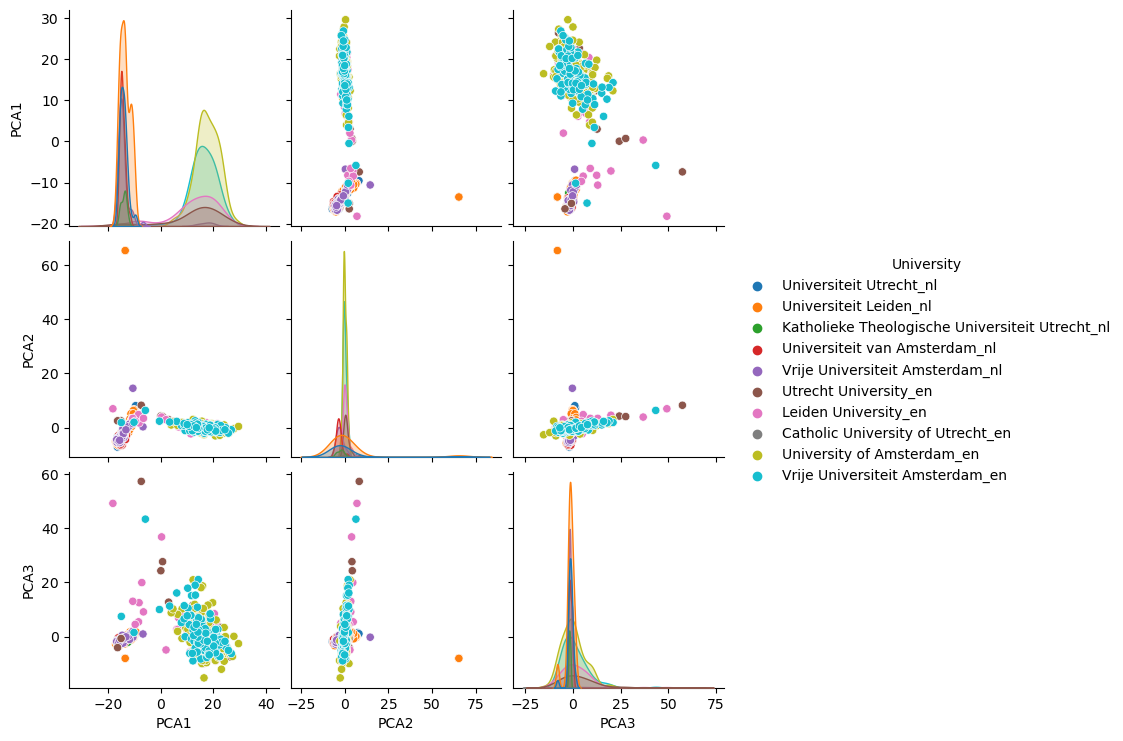

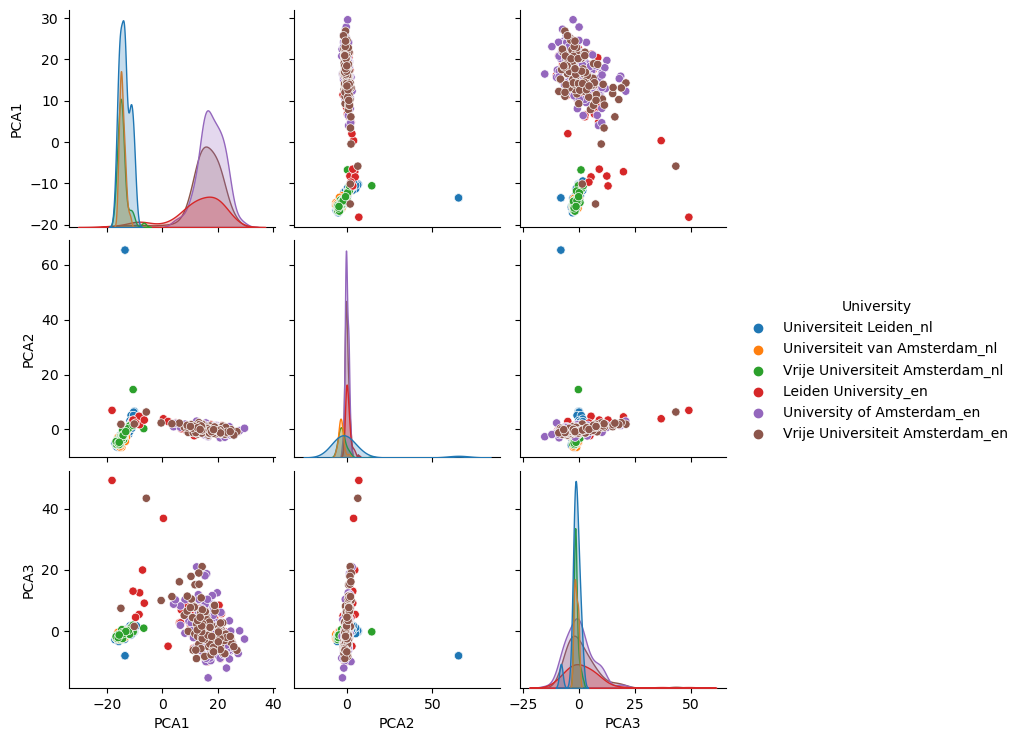

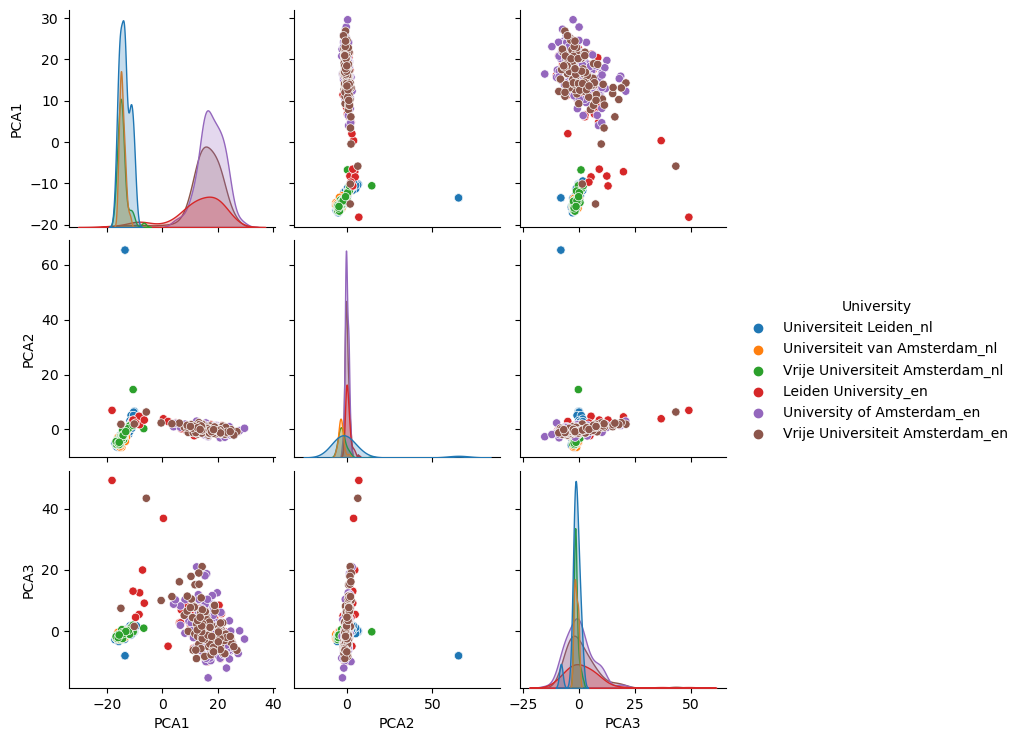

In [50]:
sns.pairplot(df_plot, x_vars=['PCA1', 'PCA2', 'PCA3'], y_vars=['PCA1', 'PCA2', 'PCA3'], hue='University' )
plt.show()

In [42]:
df_plot.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,University
266,-14.553154,-4.156163,-1.460103,0.925414,-1.638987,Universiteit Utrecht_nl
267,-11.237552,0.471244,-0.554054,6.803324,0.222415,Universiteit Utrecht_nl
268,-15.078383,-3.811049,-0.971600,-1.026867,-1.061072,Universiteit Utrecht_nl
269,-14.107048,-2.653522,-0.703842,-1.585165,-0.709639,Universiteit Utrecht_nl
270,-14.418819,-3.072662,-2.517450,-1.599127,-0.945825,Universiteit Utrecht_nl


In [70]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2, min_samples=2)


uuu = {k:v for k, v in zip(interest, pretty)}

unis = []
ncl = []
for uni in interest:
    df_cl = df_plot[df_plot.University == uni]
    clusters = dbscan.fit_predict(df_cl[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']])
    ncl.append(max(clusters)+1)
    unis.append(uuu[uni])

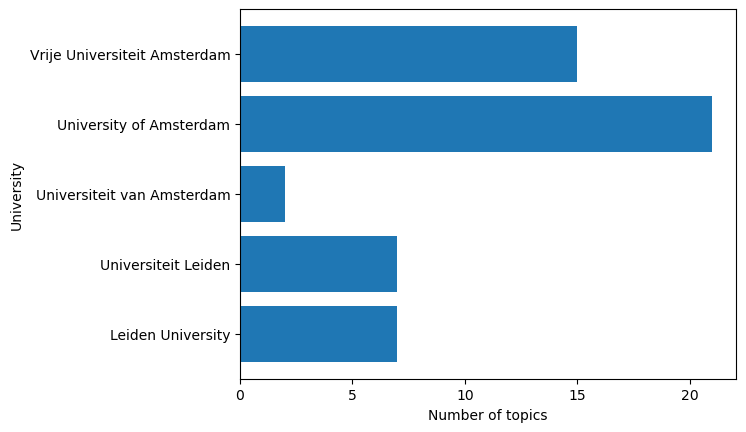

In [71]:
plt.barh(unis, ncl)
plt.ylabel('University', )
plt.xlabel('Number of topics')
plt.xticks([0,5,10,15,20])
plt.show()